# Scan analysis - shap

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import itertools

from tqdm import tqdm

import seaborn as sns

from math import floor


from matplotlib.colors import BoundaryNorm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    get_corner_annotations
)


from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE,
)

from poly2.utils import (
    get_dispersal_kernel, trait_vec, beta_dist, gamma_dist,
    get_dist_var, get_dist_mean, edge_values
)
from poly2.shap import get_shap_values
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

In [4]:
df_use = df.loc[lambda x: (x.run<8000)]

X = (
    df_use
    .drop([
        'best_dose',
        'n_pos_diff',
        'ME_var',
        'run',
    ], axis=1)
    .filter(regex='^((?!in_0).)*$')
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

# y = df_use.loc[:, ['run', 'best_dose']]

In [5]:
X.head()

,year,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


# Load XGBoost model

Takes around XX minutes

In [6]:
%%time

X_use = X

shap_values = get_shap_values(X_use)

________________________________________________________________________________
[Memory] Calling poly2.shap.get_shap_values...
get_shap_values(        year         mu         b     asymp  dec_rate    m_prop  m_scale  \
0          1  17.879734  2.744068  0.602763  1.786355  0.703574  1.95789   
1          2  17.879734  2.744068  0.602763  1.786355  0.703574  1.95789   
2          3  17.879734  2.744068  0.602763  1.786355  0.703574  1.95789   
3          4  17.879734  2.744068  0.602763  1.786355  0.703574  1.95789   
4          5  17.879734  2.744068  0.602763  1.786355  0.703574  1.95789   
...      ...        ...       ...       ...       ...       ...      ...   
279995    31  13.910574  4.382059  0.355204  1.081167  0.120044  6.09271   
279996    32  13.910574  4.382059  0.355204  1.081167  0.120044  6.09271   
279997    33  13.910574  4.382059  0.355204  1.081167  0.120044  6.09271   
279998    34  13.910574  4.382059  0.355204  1.081167  0.120044  6.09271   
279999    35  13.910

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


done
_____________________________________________get_shap_values - 7983.1s, 133.1min
Wall time: 2h 13min 3s


# Fig 4

In [7]:
HEIGHT = 4
WIDTH = 8

MAX_DISPLAY = 8

In [8]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

### A: Line plot

In [9]:
pars = (
    df
    .loc[lambda x: x.run==0]
    .head(1)
    .filter(regex='^((?!in_0).)*$')
    .drop(['n_pos_diff', 'ME_var', 'best_dose', 'year', 'run'], axis=1)
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

pars

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [10]:
n_years = 35

cf = Config(
    n_years=n_years,
    n_k=300,
    verbose=False
)

cf.k_mu = pars.mu.values[0]
cf.k_b = pars.b.values[0]
cf.asymptote = pars.asymp.values[0]
cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]

In [11]:
%%time

line_df = pd.DataFrame()

for dose in tqdm(np.linspace(0.1, 1, 10)):

    cf.doses = dose*np.ones(cf.n_years)

    sim = SimulatorOneTrait(cf)

    data = sim.run_model()
    
    tmp = pd.DataFrame(
        dict(
            dose=np.repeat(dose, n_years),
            yld=data['yield_vec'],
            year=np.arange(1, 1+n_years),
        )
    )
    
    line_df = pd.concat([line_df, tmp])
    
line_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:29<00:00, 26.91s/it]

Wall time: 4min 29s


,dose,yld,year
0,0.1,9.179550,1
1,0.1,9.179542,2
2,0.1,9.179532,3
3,0.1,9.179520,4
4,0.1,9.179505,5
...,...,...,...
30,1.0,8.996479,31
31,1.0,8.985739,32
32,1.0,8.975531,33
33,1.0,8.965832,34


In [12]:
pivoted = line_df.pivot('year', 'dose', 'yld')

pivoted.head()

dose,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,
1,9.179550,9.420743,9.584997,9.702144,9.789311,9.856586,9.910129,9.953851,9.990323,10.021293
2,9.179542,9.420730,9.584981,9.702127,9.789293,9.856567,9.910111,9.953833,9.990305,10.021275
3,9.179532,9.420711,9.584955,9.702096,9.789259,9.856531,9.910074,9.953796,9.990267,10.021238
4,9.179520,9.420684,9.584914,9.702043,9.789197,9.856462,9.909999,9.953717,9.990187,10.021156
5,9.179505,9.420645,9.584847,9.701948,9.789078,9.856322,9.909843,9.953548,9.990008,10.020970


In [13]:
line_df.head()

,dose,yld,year
0,0.1,9.179550,1
1,0.1,9.179542,2
2,0.1,9.179532,3
3,0.1,9.179520,4
4,0.1,9.179505,5


In [14]:
best_dose = (
    line_df
    .reset_index(drop=True)
    .groupby('year')
    .apply(lambda x: x.loc[x.yld.idxmax()])
    .assign(yy=10.15)
    .reset_index(drop=True)
    .loc[:, ['dose', 'year', 'yy']]
)

best_dose.head()

,dose,year,yy
0,1.0,1.0,10.15
1,1.0,2.0,10.15
2,1.0,3.0,10.15
3,1.0,4.0,10.15
4,1.0,5.0,10.15


In [15]:
eps = 0.3

bd_use = (
    pd.concat([
        best_dose.assign(year=lambda x: x.year - eps),
        best_dose.assign(year=lambda x: x.year + eps),
    ])
    .drop_duplicates()
    .sort_values('year')
)

## A

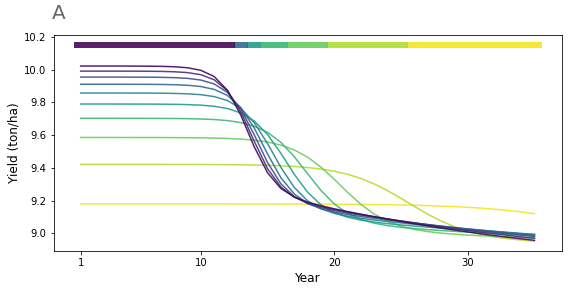

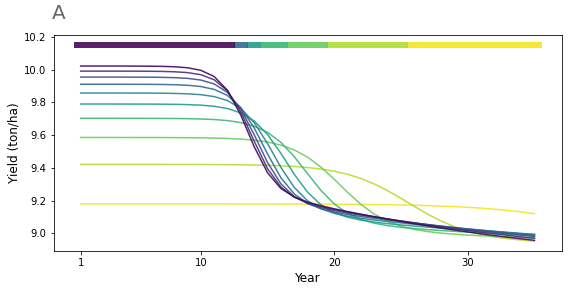

In [16]:
f, ax = plt.subplots()

alpha_A = 0.9

COLZ = sns.color_palette('viridis_r', n_colors=60)

for ind, dose in enumerate(line_df.dose.unique()):
    n_d = len(line_df.dose.unique())
    
    col_ind = floor(ind*59/(-1+n_d))
    
    colr = COLZ[col_ind]
    
    ax.plot(line_df.loc[lambda x: x.dose==dose].year,
            line_df.loc[lambda x: x.dose==dose].yld,
            alpha=alpha_A,
            c=colr)
    
    ax.plot(bd_use.loc[lambda x: x.dose==dose].year,
            bd_use.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha_A,
            lw=6)

f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.patch.set_facecolor('white')

ax.set_xlabel('Year')
ax.set_ylabel('Yield (ton/ha)')

ax.set_xticks([1,10,20,30])
ax.set_xticklabels([1,10,20,30], rotation=0)



f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'A',
    (0.09, 0.95),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

f

In [17]:
f.savefig('../figures/to_combine/fig4_1.jpg', dpi=300, bbox_inches="tight")

## B

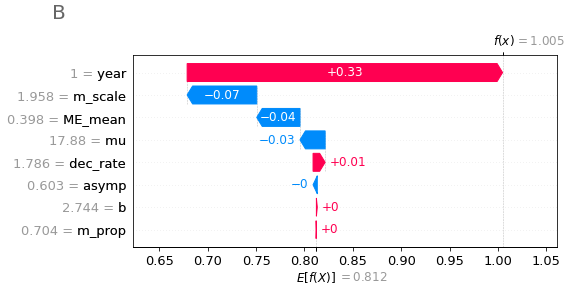

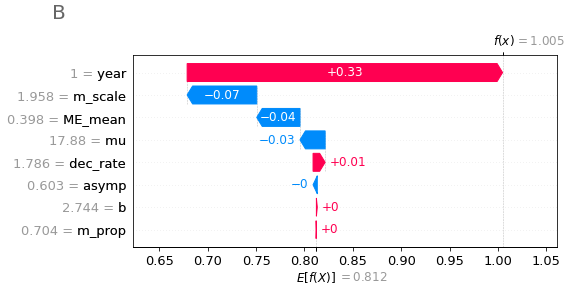

In [18]:
plt.close('all')

shap.plots.waterfall(
    shap_values[0],
    max_display=MAX_DISPLAY,
    show=False,
)

f = plt.gcf()
ax = plt.gca()


f.patch.set_facecolor('white')

ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


# ax.set_position([0, 0, 1, 1], which='both')

f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'B',
    (0.09, 0.95),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

f

In [19]:
f.savefig('../figures/to_combine/fig4_2.jpg', dpi=300, bbox_inches="tight")

In [32]:
shap_values[0, 'year']

.values =
0.32591802

.base_values =
0.8120607

.data =
1.0

## C

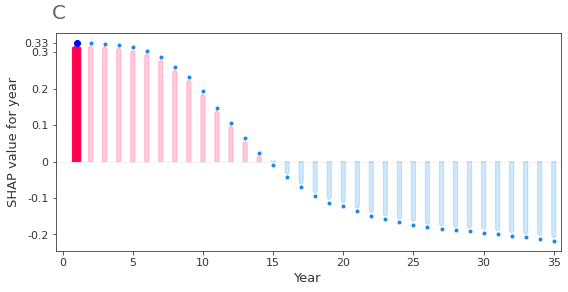

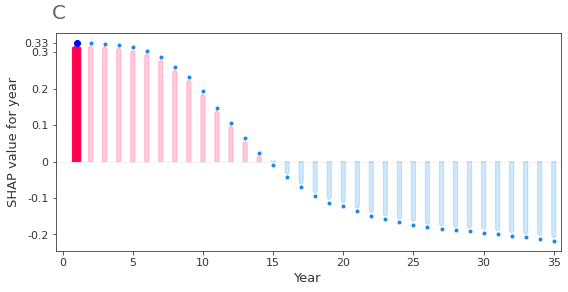

In [33]:
plt.close('all')

shap.plots.scatter(
    shap_values[1:35, "year"], 
    # color=shap_values,
    hist=False,
    show=False,
)

f = plt.gcf()

ax = plt.gca()

f.patch.set_facecolor('white')

ax.plot([-1, 36], [0,0], c='grey', alpha=0.1, lw=1)

plt.arrow(
    shap_values[0, "year"].data,
    0,
    0, 
    shap_values[0, "year"].values-0.008,
    length_includes_head=True,
    head_width=0.6,
    head_length=0.006,
    width=0.6,
    color=(1,0,80/255),
)

for year in np.arange(2,36):
    
    if shap_values[year-1, "year"].values>0:
        eps = -0.008
        col = (1,0,80/255)
    else:
        eps = +0.008
        col = (0,139/255,250/255)
    
    if abs(shap_values[year-1, "year"].values) < abs(eps):
        eps=0

    plt.arrow(
        shap_values[year-1, "year"].data,
        0,
        0, 
        shap_values[year-1, "year"].values+eps,
        length_includes_head=True,
        head_width=0.3,
        head_length=0.005,
        width=0.3,
        alpha=0.2,
        color=col,
    )

ax.scatter(shap_values[0, "year"].data, shap_values[0, "year"].values, c='b')

ax.set_xlabel('Year')
ax.set_ylabel('SHAP value for year')
ax.set_xlim([-0.5, 35.5])

ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.325])
ax.set_yticklabels([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.33])

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.tight_layout(rect=[0, 0, 1, 0.95])


plt.annotate(
    'C',
    (0.09, 0.95),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

# print(pos1)

f

In [34]:
f.savefig('../figures/to_combine/fig4_3.jpg', dpi=300, bbox_inches="tight")

### Combine panels using 'magick'

e.g.:
```
magick montage fig5_[1-2].jpg -geometry XXxYY+dx+dy output.jpg
```

Other options:

On top of each other (2 rows)
```
magick montage fig5_[1-2].jpg -tile x2 -geometry XXxYY+dx+dy output.jpg
```
Next to each other (2 cols)
```
magick montage fig5_[1-2].jpg -tile 2x -geometry XXxYY+dx+dy output.jpg
```

### Command to use
Run this in `cmd`:
```
cd Documents\Python\PhD\poly2\polygenic2\figures\to_combine
magick montage fig4_[1-3].jpg -tile x3 -geometry 1000x450+2+10 fig4.jpg
```

# Fig 5

## A

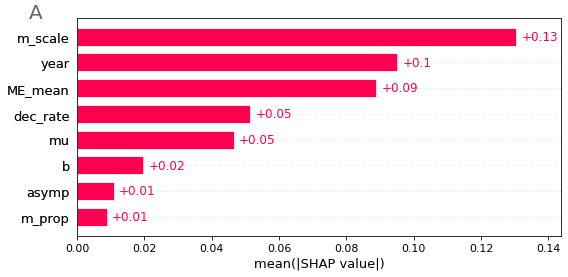

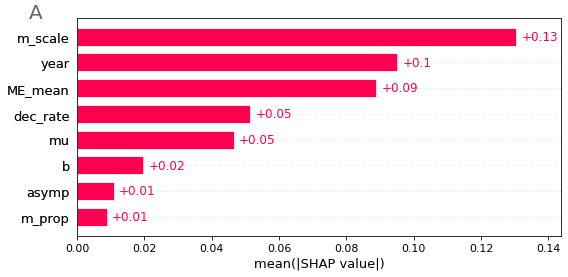

In [22]:
plt.close('all')

shap.plots.bar(shap_values, show=False)

f = plt.gcf()

ax = plt.gca()

f.set_figwidth(WIDTH)
f.set_figheight(HEIGHT)

f.patch.set_facecolor('white')


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'A',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

f

In [23]:
f.savefig('../figures/to_combine/fig5_1.jpg', dpi=300, bbox_inches="tight")

## B

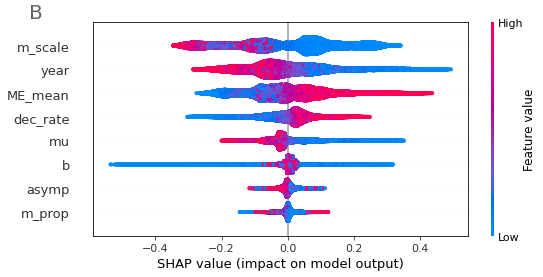

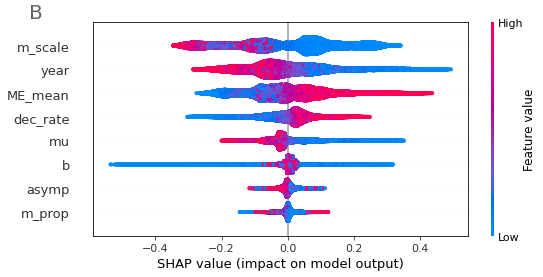

In [24]:
plt.close('all')

shap.plots.beeswarm(shap_values, plot_size=(WIDTH,HEIGHT), show=False)

f = plt.gcf()

ax = plt.gca()

f.patch.set_facecolor('white')


ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)


f.tight_layout(rect=[0, 0, 1, 0.95])

plt.annotate(
    'B',
    (0.05, 0.9),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=20,
)

f

In [25]:
f.savefig('../figures/to_combine/fig5_2.jpg', dpi=300, bbox_inches="tight")

Run this in `cmd`:
```
cd Documents\Python\PhD\poly2\polygenic2\figures\to_combine
magick montage fig5_[1-2].jpg -tile x2 -geometry 1000x450+2+20 fig5.jpg
```

# Fig 6

In [26]:
cf = Config()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = None



In [27]:
a = cf.k_mu*cf.k_b
b = cf.k_b

init_dist = gamma_dist(cf.n_k, a, b)


asymptote = 1

#
# * in trait space, get mean and variance

tv = trait_vec(cf.n_k)
# NB get_dist_var/mean needs init_dist to be shape (n_k, n_years)
reshaped = init_dist.reshape((cf.n_k, 1))
tv_var = get_dist_var(reshaped, tv)[0]
tv_mean = get_dist_mean(reshaped, tv)[0]

# NB max_effect = 1 - w + w * exp(-curv)
#               = 1 - w + w * k
max_effect_mean = 1 - asymptote + asymptote * tv_mean
max_effect_var = (asymptote**2) * tv_var

ev = edge_values(10)
dist_summary = gamma_dist(10, a, b)

In [28]:
shap_values.values.min(), shap_values.values.max()

(-0.5357818, 0.49334264)

In [38]:
ymin = -0.55
ymax = 0.55

Wall time: 14.1 s


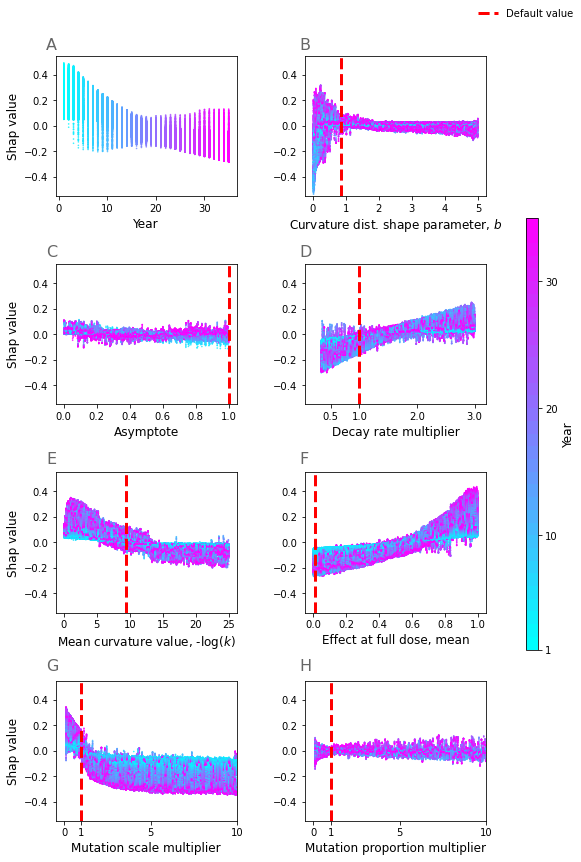

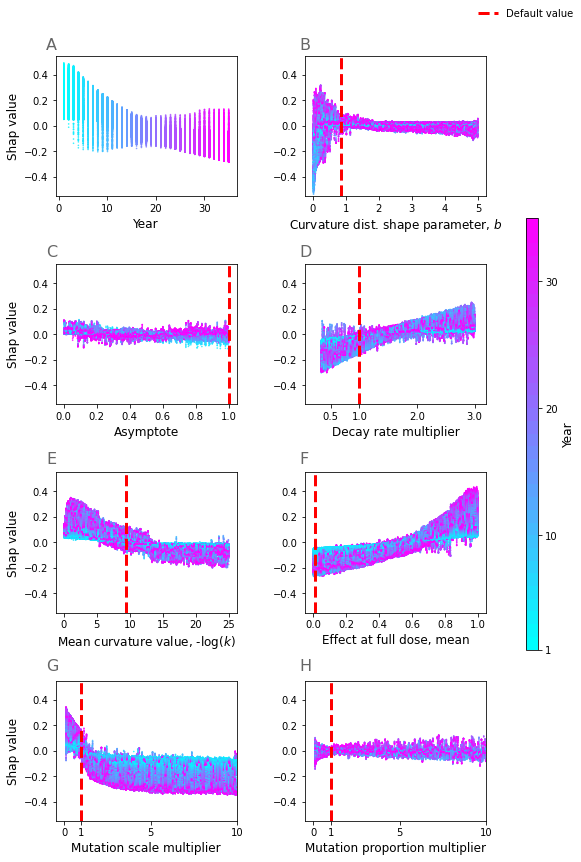

In [39]:
%%time

plt.close('all')

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title


f, ax = plt.subplots(4, 2, figsize=(8, 12))

alpha = 0.8
size = 0.4

# DATA


# grey = (0.85, 0.85, 0.85)
# blue1 = (0,1,1)
# blue2 = (0,1,0.2)
# cvals  = [0.1, 0.9, 1.1, 2, 10]
# colors = [(1,0,1), grey, grey, blue1, blue2]

# norm=plt.Normalize(min(cvals),max(cvals))
# tuples = list(zip(map(norm, cvals), colors))
# cm1 = LinearSegmentedColormap.from_list("", tuples)
# cmap1 = ScalarMappable(cmap=cm1)
# cmap2 = ScalarMappable(cmap='viridis')
# cmap3 = ScalarMappable(cmap='cool')


clrmap = plt.cm.cool  # define the colormap
cmaplist = [clrmap(i) for i in range(clrmap.N)]

# tuples = list(zip(map(norm, cvals), cmaplist))

cm3 = LinearSegmentedColormap.from_list("", cmaplist, clrmap.N)

bounds = np.linspace(1, 35, 35)
norm = BoundaryNorm(bounds, clrmap.N)

cmap3 = ScalarMappable(cmap=cm3, norm=norm)



# colors1 = cmap1.to_rgba(shap_values[:, 'm_scale'].data)
# colors1 = cmap1.to_rgba(shap_values[:, 'm_scale'].data)
# colors2 = cmap2.to_rgba(shap_values[:, 'ME_mean'].data)
colors3 = cmap3.to_rgba(shap_values[:, 'year'].data)

# A
ax[0][0].scatter(
    shap_values[:, "year"].data,
    shap_values[:, "year"].values,
    alpha=alpha, 
    color=colors3,
    # color=SHAP_BLUE,
    s=size,
)

# B
# ax[0][1].scatter(shap_values[:, "in_0p1_0p2"].data, shap_values[:, "in_0p1_0p2"].values,
#     alpha=alpha, 
#     color=colors1,
#     s=size)
ax[0][1].scatter(
    shap_values[:, "b"].data,
    shap_values[:, "b"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# C
ax[1][0].scatter(
    shap_values[:, "asymp"].data,
    shap_values[:, "asymp"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# D
ax[1][1].scatter(
    shap_values[:, "dec_rate"].data,
    shap_values[:, "dec_rate"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# E
ax[2][0].scatter(
    shap_values[:, "mu"].data,
    shap_values[:, "mu"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)

# F
ax[2][1].scatter(
    shap_values[:, "ME_mean"].data,
    shap_values[:, "ME_mean"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)



# ax[2][1].scatter(shap_values[:, "ME_var"].data, shap_values[:, "ME_var"].values,
#     alpha=alpha, 
#     color=colors1,
#     s=size)


# G
ax[3][0].scatter(
    shap_values[:, "m_scale"].data,
    shap_values[:, "m_scale"].values,
    alpha=alpha, 
    color=colors3, 
    s=size,
)

# H
ax[3][1].scatter(
    shap_values[:, "m_prop"].data, 
    shap_values[:, "m_prop"].values,
    alpha=alpha, 
    color=colors3,
    s=size,
)




# LAYOUT

# A
ax[0][0].set_xlabel('Year')


# B
ax[0][1].set_xlabel(r'Curvature dist. shape parameter, $b$')
ax[0][1].axvline(cf.k_b, color='r', label='Default value', ls='--', lw=3)


# C
ax[1][0].set_xlabel('Asymptote')
ax[1][0].set_xlim([-0.05,1.05])
ax[1][0].axvline(1, color='r', ls='--', lw=3)


# D
ax[1][1].set_xlabel('Decay rate multiplier')
ax[1][1].set_xlim([0.05, 3.2])
ax[1][1].set_xticks([0.5, 1, 2, 3])
ax[1][1].axvline(1, color='r', ls='--', lw=3)

# E
ax[2][0].set_xlabel(r'Mean curvature value, -log($k$)')
ax[2][0].axvline(cf.k_mu, color='r', ls='--', lw=3)


# F
ax[2][1].set_xlabel('Effect at full dose, mean')
ax[2][1].set_xlim([-0.05,1.05])
ax[2][1].axvline(max_effect_mean, color='r', ls='--', lw=3)

# ax[2][1].set_xlabel('Effect at full dose, variance')
# ax[2][1].axvline(max_effect_var, color='r', ls='--', lw=3)

# G
ax[3][0].set_xlabel('Mutation scale multiplier')
ax[3][0].set_xlim([-0.5,10])
ax[3][0].set_xticks([0, 1, 5, 10])
ax[3][0].axvline(1, color='r', ls='--', lw=3)


# H
ax[3][1].set_xlabel('Mutation proportion multiplier')
ax[3][1].set_xlim([-0.5,10])
ax[3][1].set_xticks([0, 1, 5, 10])
ax[3][1].axvline(1, color='r', ls='--', lw=3)


for ii, jj in itertools.product(np.arange(4), np.arange(2)):
    ax[ii][jj].spines['top'].set_visible(True)
    ax[ii][jj].spines['right'].set_visible(True)
    

    ax[ii][jj].set_ylim([ymin, ymax])
    
    if jj==0:
        ax[ii][jj].set_ylabel('Shap value')
    else:
        ax[ii][jj].set_ylabel('')

    
    





f.patch.set_facecolor('white')

f.align_ylabels()

plt.tight_layout(rect=[0, 0, 0.88, 0.95], h_pad=3, w_pad=3)

xx = 0.92
dx = 0.02
dy = 0.3

# cax1 = plt.axes([xx, 0.55, dx, dy])
# plt.colorbar(cmap1, cax=cax1, label='Mutation scale multiplier', ticks=[1, 4, 6, 8])

# cax2 = plt.axes([xx, 0.1, dx, dy])
# plt.colorbar(cmap2, cax=cax2, label='Effect at full dose, mean')

cax3 = plt.axes([xx, 0.25, dx, 0.5])
plt.colorbar(cmap3, cax=cax3, label='Year', ticks=[1, 10, 20, 30])

get_corner_annotations(2, 4, 0.08, 0.94, 0.44, 0.2395, plt)

f.legend(
    loc=1,
    framealpha=0,
)

f

In [40]:
f.savefig('../figures/paper/fig6.jpg', dpi=300, bbox_inches="tight")